In [1]:
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Pardiso

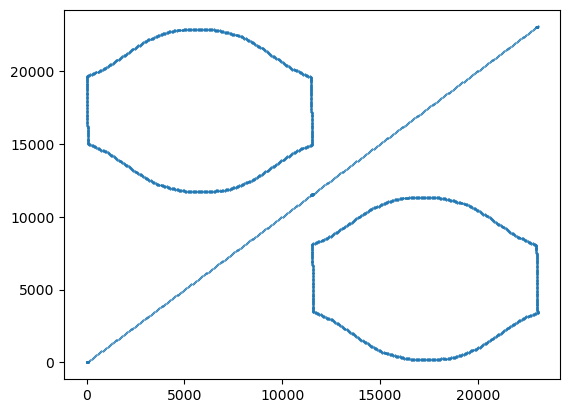

PyObject <matplotlib.collections.PathCollection object at 0x7fa5b531c3d0>

In [239]:
# Structure to represent overset grids, comprised of overlapping grids.
mutable struct SphericalSurfaceGrid
    # r, theta, phi
    # theta is the polar angle. phi is the longitude
    # latitude and longitude are defined in a local coordinate system for each grid
    
    ntheta::Int64
    nphi::Int64
    theta::Vector{Float64}
    phi::Vector{Float64}
    dtheta::Float64
    dphi::Float64
    r::Float64 # radius
    center::Vector{Float64}
    rotation::Float64
    function SphericalSurfaceGrid(ntheta,nphi,center,rotation)
        # center defines the center of this grid
        # pad each of the grids by one cell in each direction.
        dtheta = pi/2 / (ntheta-1)
        dphi = 3*pi/2 / (nphi-1)
        thetas = LinRange(pi/4-dtheta,3*pi/4+dtheta,ntheta+2)
        phis = LinRange(-3*pi/4-dphi,3*pi/4+dphi,nphi+2)
        new(ntheta+2,nphi+2,thetas,phis,thetas[2]-thetas[1],phis[2]-phis[1],1.0,center,rotation)
    end
end



mutable struct OversetGrids
    grids::Vector{SphericalSurfaceGrid}
    function OversetGrids(ntheta,nphi)
       grid1 = SphericalSurfaceGrid(ntheta,nphi,[0.,0.],0.0)
       grid2 = SphericalSurfaceGrid(ntheta,nphi,[pi/2,pi],pi/2)
    new([grid1,grid2])
    end
end

# degrees of freedom will be laid out starting with the first grid and proceeding through the grids.
@inline node(i,j,grid::Int64,grids::OversetGrids) = (grid-1)*grids.grids[1].ntheta*grids.grids[1].nphi + (j-1)*grids.grids[grid].ntheta + i

function sph2cart(r::Float64,theta::Float64,phi::Float64)
    x = r*sin(theta)*cos(phi)
    y = r*sin(theta)*sin(phi)
    z = r*cos(theta)
    return x,y,z
end

function cart2sph(x::Float64,y::Float64,z::Float64)
   r = (x^2+y^2+z^2)^0.5
   theta = acos(z/r)
   phi   = atan(y,x)
   return r,theta,phi
end

function grid2xyz(grid::SphericalSurfaceGrid ; yang=false)
    x = zeros(grid.ntheta,grid.nphi)
    y = zeros(grid.ntheta,grid.nphi)
    z = zeros(grid.ntheta,grid.nphi)
    for i in 1:grid.ntheta
        for j in 1:grid.nphi
            xt,yt,zt = sph2cart(grid.r,grid.theta[i],grid.phi[j])
            x[i,j] = xt
            y[i,j] = yt
            z[i,j] = zt
        end
    end
    if yang
        return -x,z,y
    else
        return  x,y,z
    end
end
# define one grid to be the main grid
# in the overlapping regions, other grids will have values at overlapping coordinates prescribed.
# let r=1, 

# compute the overlaps. assemble a matrix whose rows correspond to 
# degree of freedom on grid 2, columns correspond to weights that interpolate quantities from grid 1.

# (on grid 2):
# loop over points
grids = OversetGrids(20*3 + 1,3* 3*20+1)
grid2 = grids.grids[2]
grid1 = grids.grids[1]
yang_xyz = grid2xyz(grids.grids[2] ; yang=true)

enclosed = Matrix{Float64}(undef,grid2.ntheta,grid2.nphi)
match = Matrix{Bool}(undef,grid2.ntheta,grid2.nphi)
for i in 1:grid2.ntheta
    for j in 1:grid2.nphi
        x,y,z = sph2cart(grid2.r,grid2.theta[i],grid2.phi[j])
        r,t,p = cart2sph(-x,z,y)
        if t > grid1.theta[1] && t < grid1.theta[end] && p > grid1.phi[1] && p < grid1.phi[end]
            enclosed[i,j] = true
            match[i,j] = any(isapprox.(t,grid1.theta)) && any(isapprox.(p,grid1.phi))
        else
            enclosed[i,j] = false
            match[i,j] = false
        end        
    end
end

# grid2 -> grid1 (x,y,z) -> (-x,z,y)
# grid1 -> grid2 (x,y,z) -> (-x,z,y) (clever...)
function compute_constraints(grids::OversetGrids)
    #    transform point to grid 1 coordinates
    #    compute whether this point is enclosed within grid 1.
    #    no -> do nothing
    #    yes -> there will be an entry in the matrix.

    grid1 = grids.grids[1]
    grid2 = grids.grids[2]
    
    nn = 5*2*(2*grid1.ntheta + 2*grid1.nphi);
    row = Vector{Int64}(undef,nn)
    col = Vector{Int64}(undef,nn)
    val = Vector{Float64}(undef,nn)
    
    k=1;
    for cycle = 1:2
        local grid1
        local grid2
        if cycle == 1
            grid1 = grids.grids[1]
            grid2 = grids.grids[2]
            this = 1
            other = 2
        else
            grid1 = grids.grids[2]
            grid2 = grids.grids[1]
            this = 2
            other = 1
        end
        for i in 1:grid2.ntheta 
            for j in 1:grid2.nphi # left/right columns
                if i == 1 || i == grid2.ntheta || j == 1 || j == grid2.nphi
                    x,y,z = sph2cart(grid2.r,grid2.theta[i],grid2.phi[j])
                    r,t,p = cart2sph(-x,z,y)
                    t_cell = Int64( floor( (t-grid1.theta[1])/grid1.dtheta )+1 )
#                     t_call = t_cell > grid1.ntheta-1 ? grid1.ntheta-1 : grid1.ntheta-1
                    p_cell = Int64( floor( (p-grid1.phi[1])/grid1.dphi )+1 )
#                     p_call = p_cell > grid1.nphi-1 ? grid1.nphi-1 : grid1.nphi-1
                    if t_cell == 1 || t_cell == grid1.ntheta-1
                        print("nooo!")
                    end
                    if p_cell == 1 || p_cell == grid1.nphi-1
                        print("nooo!")
                    end
                    
                    w_t = (t-grid1.theta[t_cell])/grid1.dtheta
                    w_p = (p-grid1.phi[p_cell])/grid1.dphi
                    # constrain the value at node i,j on the other grid...
                    this_row = node(i,j,other,grids)
                    row[k] = this_row
                    col[k] = this_row
                    val[k] = -1.0
                    k+=1;            
                    # ... to be the interpolated value from the four neighbors on this grid.
                    row[k] = this_row
                    col[k] = node(t_cell,p_cell,this,grids)
                    val[k] = (1.0-w_t)*(1.0-w_p)
                    k+=1;
                    row[k] = this_row
                    col[k] = node(t_cell+1,p_cell,this,grids)
                    val[k] = (w_t)*(1.0-w_p)
                    k+=1;
                    row[k] = this_row
                    col[k] = node(t_cell,p_cell+1,this,grids)
                    val[k] = (1.0-w_t)*(w_p)
                    k+=1;
                    row[k] = this_row
                    col[k] = node(t_cell+1,p_cell+1,this,grids)
                    val[k] = (w_t)*(w_p)
                    k+=1; 
                end
            end
        end
    end

    row = row[1:k-1]
    col = col[1:k-1]
    val = val[1:k-1]
    return row,col,val
end

rowc,colc,valc = compute_constraints(grids)
figure()
scatter(rowc,colc,s=0.1)

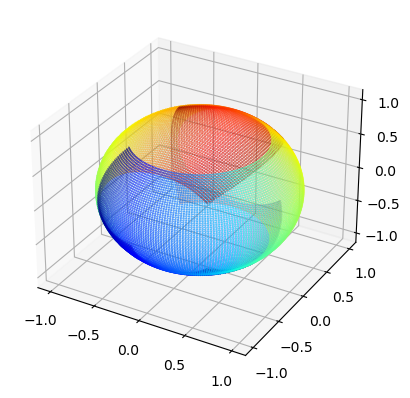

In [240]:
x,y,z = grid2xyz(grids.grids[1])

dof1 = [node(i,j,1,grids) for i in 1:grids.grids[1].ntheta, j in 1:grids.grids[1].nphi]
dof2 = [node(i,j,2,grids) for i in 1:grids.grids[1].ntheta, j in 1:grids.grids[2].nphi]

using PyPlot

fig = figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(x,y,z,c=dof1,s=0.1,cmap=get_cmap("jet"))
ax.scatter(-x,z,y,c=dof2,s=0.1,cmap=get_cmap("jet"))

fig.show()

In [241]:
enclosed
print(size(enclosed))
print(size(grid2.phi))


(63, 183)(183,)

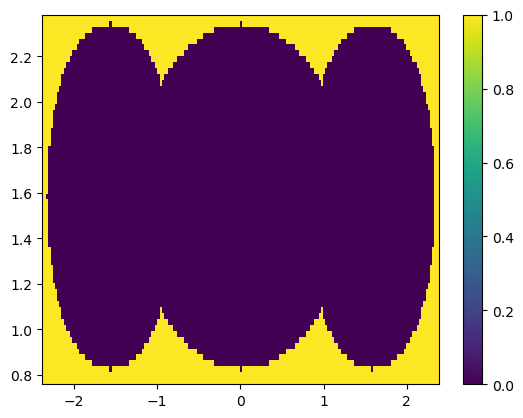

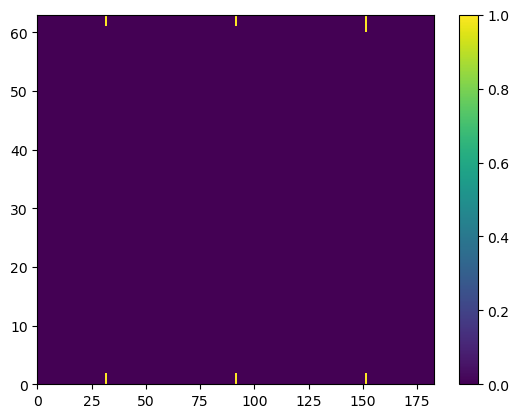

PyObject <matplotlib.colorbar.Colorbar object at 0x7fa5b521c400>

In [242]:
figure()
pcolormesh(grid2.phi, grid2.theta, enclosed)
colorbar()
figure()
pcolormesh(match)
 colorbar()

In [243]:
test = [sph2cart(1.0,t,p) for t in grid1.theta, p in grid1.phi]


63×183 Matrix{Tuple{Float64, Float64, Float64}}:
 (-0.499315, -0.473832, 0.725374)   …  (-0.499315, 0.473832, 0.725374)
 (-0.512917, -0.48674, 0.707107)       (-0.512917, 0.48674, 0.707107)
 (-0.526168, -0.499315, 0.688355)      (-0.526168, 0.499315, 0.688355)
 (-0.539058, -0.511547, 0.669131)      (-0.539058, 0.511547, 0.669131)
 (-0.551579, -0.523429, 0.649448)      (-0.551579, 0.523429, 0.649448)
 (-0.563722, -0.534952, 0.62932)    …  (-0.563722, 0.534952, 0.62932)
 (-0.575478, -0.546108, 0.608761)      (-0.575478, 0.546108, 0.608761)
 (-0.58684, -0.556891, 0.587785)       (-0.58684, 0.556891, 0.587785)
 (-0.5978, -0.567291, 0.566406)        (-0.5978, 0.567291, 0.566406)
 (-0.60835, -0.577303, 0.544639)       (-0.60835, 0.577303, 0.544639)
 (-0.618483, -0.586919, 0.522499)   …  (-0.618483, 0.586919, 0.522499)
 (-0.628193, -0.596133, 0.5)           (-0.628193, 0.596133, 0.5)
 (-0.637471, -0.604938, 0.477159)      (-0.637471, 0.604938, 0.477159)
 ⋮                                  ⋱  

In [244]:
[cart2sph(a[1],a[2],a[3]) for a in test]

63×183 Matrix{Tuple{Float64, Float64, Float64}}:
 (1.0, 0.759218, -2.38237)  …  (1.0, 0.759218, 2.38237)
 (1.0, 0.785398, -2.38237)     (1.0, 0.785398, 2.38237)
 (1.0, 0.811578, -2.38237)     (1.0, 0.811578, 2.38237)
 (1.0, 0.837758, -2.38237)     (1.0, 0.837758, 2.38237)
 (1.0, 0.863938, -2.38237)     (1.0, 0.863938, 2.38237)
 (1.0, 0.890118, -2.38237)  …  (1.0, 0.890118, 2.38237)
 (1.0, 0.916298, -2.38237)     (1.0, 0.916298, 2.38237)
 (1.0, 0.942478, -2.38237)     (1.0, 0.942478, 2.38237)
 (1.0, 0.968658, -2.38237)     (1.0, 0.968658, 2.38237)
 (1.0, 0.994838, -2.38237)     (1.0, 0.994838, 2.38237)
 (1.0, 1.02102, -2.38237)   …  (1.0, 1.02102, 2.38237)
 (1.0, 1.0472, -2.38237)       (1.0, 1.0472, 2.38237)
 (1.0, 1.07338, -2.38237)      (1.0, 1.07338, 2.38237)
 ⋮                          ⋱  
 (1.0, 2.0944, -2.38237)       (1.0, 2.0944, 2.38237)
 (1.0, 2.12058, -2.38237)      (1.0, 2.12058, 2.38237)
 (1.0, 2.14675, -2.38237)      (1.0, 2.14675, 2.38237)
 (1.0, 2.17293, -2.38237)      

In [245]:
[(1.0,t,p) for t in grid1.theta, p in grid1.phi]

63×183 Matrix{Tuple{Float64, Float64, Float64}}:
 (1.0, 0.759218, -2.38237)  …  (1.0, 0.759218, 2.38237)
 (1.0, 0.785398, -2.38237)     (1.0, 0.785398, 2.38237)
 (1.0, 0.811578, -2.38237)     (1.0, 0.811578, 2.38237)
 (1.0, 0.837758, -2.38237)     (1.0, 0.837758, 2.38237)
 (1.0, 0.863938, -2.38237)     (1.0, 0.863938, 2.38237)
 (1.0, 0.890118, -2.38237)  …  (1.0, 0.890118, 2.38237)
 (1.0, 0.916298, -2.38237)     (1.0, 0.916298, 2.38237)
 (1.0, 0.942478, -2.38237)     (1.0, 0.942478, 2.38237)
 (1.0, 0.968658, -2.38237)     (1.0, 0.968658, 2.38237)
 (1.0, 0.994838, -2.38237)     (1.0, 0.994838, 2.38237)
 (1.0, 1.02102, -2.38237)   …  (1.0, 1.02102, 2.38237)
 (1.0, 1.0472, -2.38237)       (1.0, 1.0472, 2.38237)
 (1.0, 1.07338, -2.38237)      (1.0, 1.07338, 2.38237)
 ⋮                          ⋱  
 (1.0, 2.0944, -2.38237)       (1.0, 2.0944, 2.38237)
 (1.0, 2.12058, -2.38237)      (1.0, 2.12058, 2.38237)
 (1.0, 2.14675, -2.38237)      (1.0, 2.14675, 2.38237)
 (1.0, 2.17293, -2.38237)      

In [246]:
dof1

63×183 Matrix{Int64}:
  1   64  127  190  253  316  379  442  …  11215  11278  11341  11404  11467
  2   65  128  191  254  317  380  443     11216  11279  11342  11405  11468
  3   66  129  192  255  318  381  444     11217  11280  11343  11406  11469
  4   67  130  193  256  319  382  445     11218  11281  11344  11407  11470
  5   68  131  194  257  320  383  446     11219  11282  11345  11408  11471
  6   69  132  195  258  321  384  447  …  11220  11283  11346  11409  11472
  7   70  133  196  259  322  385  448     11221  11284  11347  11410  11473
  8   71  134  197  260  323  386  449     11222  11285  11348  11411  11474
  9   72  135  198  261  324  387  450     11223  11286  11349  11412  11475
 10   73  136  199  262  325  388  451     11224  11287  11350  11413  11476
 11   74  137  200  263  326  389  452  …  11225  11288  11351  11414  11477
 12   75  138  201  264  327  390  453     11226  11289  11352  11415  11478
 13   76  139  202  265  328  391  454     11227  1129

In [247]:
dof2

63×183 Matrix{Int64}:
 11530  11593  11656  11719  11782  …  22744  22807  22870  22933  22996
 11531  11594  11657  11720  11783     22745  22808  22871  22934  22997
 11532  11595  11658  11721  11784     22746  22809  22872  22935  22998
 11533  11596  11659  11722  11785     22747  22810  22873  22936  22999
 11534  11597  11660  11723  11786     22748  22811  22874  22937  23000
 11535  11598  11661  11724  11787  …  22749  22812  22875  22938  23001
 11536  11599  11662  11725  11788     22750  22813  22876  22939  23002
 11537  11600  11663  11726  11789     22751  22814  22877  22940  23003
 11538  11601  11664  11727  11790     22752  22815  22878  22941  23004
 11539  11602  11665  11728  11791     22753  22816  22879  22942  23005
 11540  11603  11666  11729  11792  …  22754  22817  22880  22943  23006
 11541  11604  11667  11730  11793     22755  22818  22881  22944  23007
 11542  11605  11668  11731  11794     22756  22819  22882  22945  23008
     ⋮                       

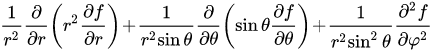

In [248]:
# discretize the poisson equation on grid1.
grid = grids.grids[1]
N = grid.ntheta*grid.nphi*2
row = Vector{Int64}(undef,5*N)
col = Vector{Int64}(undef,5*N)
val = Vector{Float64}(undef,5*N)
R = Vector{Float64}(undef,N)
k = 1
for igrid in 1:2
    grid = grids.grids[igrid]
    for j in 1:grid.nphi
        for i in 1:grid.ntheta
            this_row::Int64 = node(i,j,igrid,grids)
            if (i==1 || i == grid.ntheta || j == 1 || j == grid.nphi)
                if false
                row[k] = this_row
                col[k] = this_row
                val[k] = 1.0
                k+=1
                end
                R[this_row] = 0.0
            else
                # center
                theta_cp = 0.5*(grid.theta[i+1]+grid.theta[i])
                theta_cm = 0.5*(grid.theta[i]  +grid.theta[i-1])
                row[k] = this_row
                col[k] = this_row
                val[k] = -1.0/grid.r^2 * sin(theta_cp)/sin(grid.theta[i])/grid.dtheta^2 +
                    -1.0/grid.r^2 * sin(theta_cm)/sin(grid.theta[i])/grid.dtheta^2 +
                    -1.0/grid.r^2/sin( grid.theta[i] )^2 / grid.dphi^2 +
                    -1.0/grid.r^2/sin( grid.theta[i] )^2 / grid.dphi^2;
                k+=1
                # +theta
                row[k] = this_row
                col[k] = node(i+1,j,igrid,grids)
                val[k] = 1.0/grid.r^2 * sin(theta_cp)/sin(grid.theta[i])/grid.dtheta^2
                k+=1
                # -theta
                row[k] = this_row
                col[k] = node(i-1,j,igrid,grids)
                val[k] = 1.0/grid.r^2 * sin(theta_cm)/sin(grid.theta[i])/grid.dtheta^2
                k+=1
                # +phi
                row[k] = this_row
                col[k] = node(i,j+1,igrid,grids)
                val[k] = 1.0/grid.r^2/sin( grid.theta[i] )^2 / grid.dphi^2
                k+=1
                # -phi
                row[k] = this_row
                col[k] = node(i,j-1,igrid,grids)
                val[k] = 1.0/grid.r^2/sin( grid.theta[i] )^2 / grid.dphi^2
                k+=1
                R[this_row] = (igrid == 1 && abs( pi/2-grid.theta[i] ) < pi/8 && abs(grid.phi[j]) < pi/8) ? 1.0 : 0.0
            end
        end
    end
end
row = cat(row[1:k-1] ,rowc ; dims=1)
col = cat(col[1:k-1] ,colc ; dims=1)
val = cat(val[1:k-1] ,valc ; dims=1)
L = sparse(row,col,val);
solution = L\R;

In [249]:
L

23058×23058 SparseMatrixCSC{Float64, Int64} with 115290 stored entries:
⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡼⠉⠉⠉⠉⠉⠉⠉⠉⢧⠀⠀⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠞⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀
⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠞⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⡄⠀
⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢰⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⡄
⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⢹⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣰⠃
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠹⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡴⠃⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡴⠋⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⠀⠀⠀⠀⠘⢦⣀⣀⣀⣀⣀⣀⣀⣠⡞⠁⠀⠀⠀⠀
⠀⠀⠀⠀⢀⡼⠋⠉⠉⠉⠉⠉⠉⠉⠳⡄⠀⠀⠀⠀⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⣠⠞⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⢠⠞⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⣆⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢠⠏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⣇⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣼⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀
⠘⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀
⠀⠘⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡴⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡴⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀
⠀⠀⠀⠀⠀⢳⣀⣀⣀⣀⣀⣀⣀⣀⡞⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦

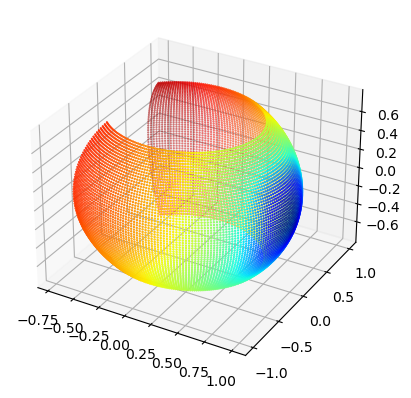

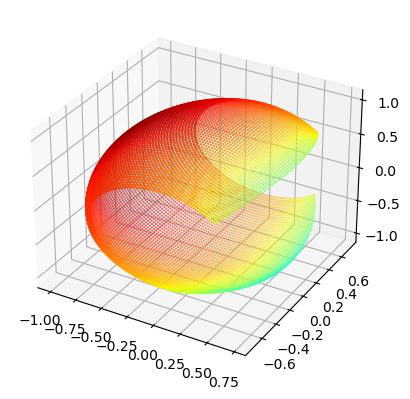

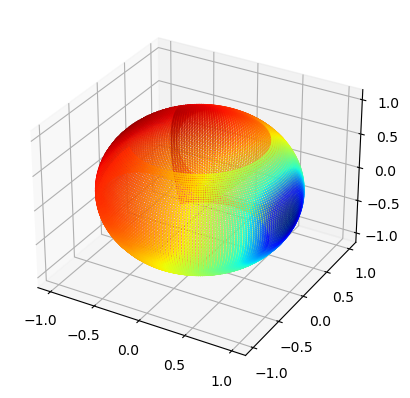

In [251]:
dof1 = [node(i,j,1,grids) for j in 1:grids.grids[1].nphi, i in 1:grids.grids[1].ntheta]
dof2 = [node(i,j,2,grids) for i in 1:grids.grids[1].ntheta, j in 1:grids.grids[2].nphi]

using PyPlot

fig = figure()
ax = fig.add_subplot(projection="3d")
for i in 1:2
    x,y,z = grid2xyz(grids.grids[i])
    N = grids.grids[i].ntheta * grids.grids[i].nphi
    vmin = minimum(solution)
    vmax = maximum(solution)
    ax.scatter(x,y,z,c=reshape(solution[1:N],grids.grids[i].ntheta,grids.grids[i].nphi),s=0.2,cmap=get_cmap("jet"),vmin=vmin,vmax=vmax)
#     ax.scatter(-x,z,y,c=reshape(solution[N+1:end],grids.grids[i].ntheta,grids.grids[i].nphi),s=0.2,cmap=get_cmap("jet"),vmin=vmin,vmax=vmax)
end
fig = figure()
ax = fig.add_subplot(projection="3d")
for i in 1:2
    x,y,z = grid2xyz(grids.grids[i])
    N = grids.grids[i].ntheta * grids.grids[i].nphi
    vmin = minimum(solution)
    vmax = maximum(solution)
#     ax.scatter(x,y,z,c=reshape(solution[1:N],grids.grids[i].ntheta,grids.grids[i].nphi),s=0.01,cmap=get_cmap("jet"),vmin=vmin,vmax=vmax)
    ax.scatter(-x,z,y,c=reshape(solution[N+1:end],grids.grids[i].ntheta,grids.grids[i].nphi),s=0.2,cmap=get_cmap("jet"),vmin=vmin,vmax=vmax)
end
fig = figure()
ax = fig.add_subplot(projection="3d")
for i in 1:2
    x,y,z = grid2xyz(grids.grids[i])
    N = grids.grids[i].ntheta * grids.grids[i].nphi
    vmin = minimum(solution)
    vmax = maximum(solution)
    ax.scatter(x,y,z,c=reshape(solution[1:N],grids.grids[i].ntheta,grids.grids[i].nphi),s=0.2,cmap=get_cmap("jet"),vmin=vmin,vmax=vmax)
    ax.scatter(-x,z,y,c=reshape(solution[N+1:end],grids.grids[i].ntheta,grids.grids[i].nphi),s=0.2,cmap=get_cmap("jet"),vmin=vmin,vmax=vmax)
end
# ax.scatter(-x,z,y,c=dof2,s=0.1,cmap=get_cmap("jet"))

fig.show()

In [72]:
size(dof1)

(93, 183)

In [77]:
size(x)

(93, 183)

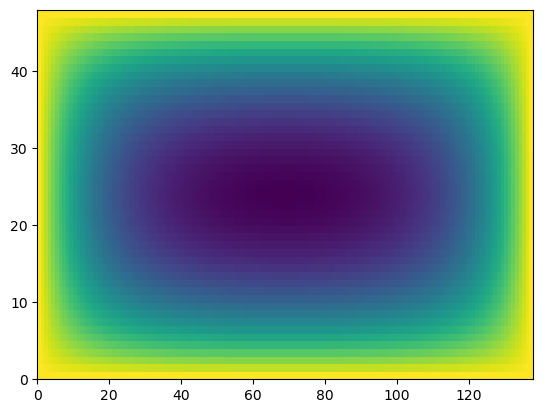

In [59]:
figure()
pcolor(reshape(solution[1:N],grid.ntheta,grid.nphi))
show()

In [16]:
x


93×183 Matrix{Float64}:
 -0.503887  -0.491198  -0.478171  …  -0.478171  -0.491198  -0.503887
 -0.512917  -0.5       -0.48674      -0.48674   -0.5       -0.512917
 -0.521791  -0.50865   -0.495161     -0.495161  -0.50865   -0.521791
 -0.530505  -0.517145  -0.503431     -0.503431  -0.517145  -0.530505
 -0.539058  -0.525483  -0.511547     -0.511547  -0.525483  -0.539058
 -0.547447  -0.53366   -0.519508  …  -0.519508  -0.53366   -0.547447
 -0.555669  -0.541675  -0.52731      -0.52731   -0.541675  -0.555669
 -0.563722  -0.549525  -0.534952     -0.534952  -0.549525  -0.563722
 -0.571603  -0.557208  -0.542431     -0.542431  -0.557208  -0.571603
 -0.57931   -0.564721  -0.549744     -0.549744  -0.564721  -0.57931
 -0.58684   -0.572061  -0.556891  …  -0.556891  -0.572061  -0.58684
 -0.594192  -0.579228  -0.563867     -0.563867  -0.579228  -0.594192
 -0.601363  -0.586218  -0.570672     -0.570672  -0.586218  -0.601363
  ⋮                               ⋱   ⋮                    
 -0.594192  -0.579228

In [36]:
grid1.dtheta

0.03490658503988664

In [37]:
grid1.dphi

0.034906585039886195

In [81]:
cat(row,rowc ; dims=1)

65136-element Vector{Int64}:
     1
     2
     3
     4
     5
     6
     7
     8
     9
    10
    11
    12
    13
     ⋮
 13152
 13152
 13200
 13200
 13200
 13200
 13200
 13248
 13248
 13248
 13248
 13248

In [98]:
rowc

1840-element Vector{Int64}:
  6625
  6625
  6625
  6625
  6625
  6673
  6673
  6673
  6673
  6673
  6721
  6721
  6721
     ⋮
 13152
 13152
 13200
 13200
 13200
 13200
 13200
 13248
 13248
 13248
 13248
 13248